In [3]:
import sys, os
sys.path.append('./src')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset

from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


import pandas as pd 
import numpy as np
import random 
from sklearn.preprocessing import StandardScaler
from umap import UMAP

from model import Encoder, Decoder, OutputLayer
from loss_function import ZINB, maximum_mean_discrepancy, TripletLoss, CircleLoss
from train import train_epoch_mmd

from dataset import dataset
from scipy import sparse

import utils
import model
import train
from sklearn.metrics import adjusted_rand_score as ARI
from sklearn.metrics import normalized_mutual_info_score as NMI
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from sklearn.preprocessing import LabelEncoder
from metrics import *
import anndata as ad

In [4]:
le = LabelEncoder()

## New version for 8 batches
There seems to be some issue with the original implementation, so I re-write the training and dataset generation code. The clusters are better separated this time. Please check the new code when you have time.

-Ziqi

In [6]:
class dataset(Dataset):

    def __init__(self, counts, anno, time_point, batch_id, group_id):

        assert not len(counts) == 0, "Count is empty"
        # normalize the count
        self.libsizes = np.tile(np.sum(counts, axis = 1, keepdims = True), (1, counts.shape[1]))
        # is the tile necessary?
        
        self.counts_norm = counts/self.libsizes * 100
        self.counts_norm = np.log1p(self.counts_norm)
        self.counts = torch.FloatTensor(counts)

        # further standardize the count
        self.counts_stand = torch.FloatTensor(StandardScaler().fit_transform(self.counts_norm))
        self.anno = torch.Tensor(anno)
        self.libsizes = torch.FloatTensor(self.libsizes)
        self.time_point = torch.Tensor(time_point)
        self.batch_id = torch.Tensor(batch_id)
        self.group_id = torch.Tensor(group_id)

    def __len__(self):
        return self.counts.shape[0]
    
    def __getitem__(self, idx):
        # data original data, index the index of cell, label, corresponding labels, batch, corresponding batch number
        if self.anno is not None:
            sample = {"batch_id": self.batch_id[idx], "time_point": self.time_point[idx], "group_id": self.group_id[idx], "count": self.counts[idx,:], "count_stand": self.counts_stand[idx,:], "index": idx, "anno": self.anno[idx], "libsize": self.libsizes[idx]}
        else:
            sample = {"batch_id": self.batch_id[idx], "time_point": self.time_point[idx], "group_id": self.group_id[idx],  "count": self.counts[idx,:], "count_stand": self.counts_stand[idx,:], "index": idx, "libsize": self.libsizes[idx]}
        return sample


In [4]:
batch_info = pd.read_csv(r'./data/scp_gex_matrix/processed_sepsis_7533/sepsis_processed_batch_info.csv')

In [5]:
batch_info

Unnamed: 0       Control      Leuk-UTI           URO       Int-URO  \
0     batch_1  (4566, 7533)  (3864, 7533)           NaN           NaN   
1     batch_2   (705, 7533)   (538, 7533)           NaN           NaN   
2     batch_3  (5281, 7533)  (1783, 7533)  (2005, 7533)           NaN   
3     batch_4  (1144, 7533)   (155, 7533)   (260, 7533)           NaN   
4     batch_5  (5952, 7533)  (4646, 7533)  (2569, 7533)           NaN   
5     batch_6  (1785, 7533)  (1366, 7533)   (376, 7533)           NaN   
6     batch_7  (1701, 7533)  (4137, 7533)  (3371, 7533)  (1981, 7533)   
7     batch_8   (568, 7533)   (343, 7533)    (14, 7533)   (129, 7533)   
8    batch_11  (4848, 7533)  (4891, 7533)           NaN  (1848, 7533)   
9    batch_12  (2163, 7533)   (511, 7533)           NaN   (232, 7533)   
10   batch_13  (3247, 7533)           NaN  (3465, 7533)  (2938, 7533)   
11   batch_14  (1828, 7533)           NaN   (324, 7533)   (213, 7533)   
12   batch_15  (6584, 7533)           NaN  (1573, 7533)  (2505, 7533)   
13   batch_16  (3201, 7533)           NaN   (114, 7533)   (381, 7533)   
14   batch_17  (3696, 7533)           NaN   (371, 7533)  (3370, 7533)   
15   batch_18  (1586, 7533)           NaN     (3, 7533)   (278, 7533)   
16    batch_9           NaN           NaN  (1670, 7533)           NaN   
17   batch_10           NaN           NaN    (21, 7533)           NaN   
18   batch_19           NaN           NaN           NaN           NaN   
19   batch_20           NaN           NaN           NaN           NaN   
20   batch_21           NaN           NaN           NaN           NaN   
21   batch_22           NaN           NaN           NaN           NaN   
22   batch_23           NaN           NaN           NaN           NaN   
23   batch_24           NaN           NaN           NaN           NaN   
24   batch_27           NaN           NaN           NaN           NaN   
25   batch_28           NaN           NaN           NaN           NaN   
26   batch_26           NaN           NaN           NaN           NaN   
27   batch_29           NaN           NaN           NaN           NaN   
28   batch_31           NaN           NaN           NaN           NaN   
29   batch_32           NaN           NaN           NaN           NaN   
30   batch_33           NaN           NaN           NaN           NaN   
31   batch_34           NaN           NaN           NaN           NaN   
32   batch_35           NaN           NaN           NaN           NaN   

       ICU-NoSEP       ICU-SEP       Bac-SEP  
0            NaN           NaN           NaN  
1            NaN           NaN           NaN  
2            NaN           NaN           NaN  
3            NaN           NaN           NaN  
4            NaN           NaN           NaN  
5            NaN           NaN           NaN  
6            NaN           NaN           NaN  
7            NaN           NaN           NaN  
8            NaN           NaN           NaN  
9            NaN           NaN           NaN  
10           NaN           NaN           NaN  
11           NaN           NaN           NaN  
12           NaN           NaN           NaN  
13           NaN           NaN           NaN  
14           NaN           NaN           NaN  
15           NaN           NaN           NaN  
16           NaN           NaN           NaN  
17           NaN           NaN           NaN  
18  (2323, 7533)  (1948, 7533)           NaN  
19    (78, 7533)    (11, 7533)           NaN  
20  (1406, 7533)   (416, 7533)           NaN  
21    (84, 7533)           NaN           NaN  
22  (1536, 7533)           NaN           NaN  
23   (667, 7533)           NaN           NaN  
24  (1316, 7533)   (500, 7533)           NaN  
25   (609, 7533)    (60, 7533)           NaN  
26           NaN   (308, 7533)           NaN  
27           NaN  (4754, 7533)           NaN  
28           NaN           NaN  (3229, 7533)  
29           NaN           NaN   (578, 7533)  
30           NaN           NaN   (834, 7533)  
31           NaN

In [7]:
batch_lst = [['Control', 4],
             ['Leuk-UTI', 3],
             ['Int-URO', 7],
             ['URO', 13],
             ['Bac-SEP', 31],
             ['ICU-SEP', 27],
             ['ICU-NoSEP', 19],
             ['Control', 6], 
             ['Leuk-UTI', 5], 
             ['Int-URO', 11], 
             ['URO', 15], 
             ['Bac-SEP', 33], 
             ['ICU-SEP', 29], 
             ['ICU-NoSEP', 21]]

# format: "Cohort Name": ([batch ids], time_point, UTI-label)
batch_dict = {
              'Control': ([4, 6], 0, 0),
              'Leuk-UTI': ([3, 5], 1, 1),
              'Int-URO': ([7, 11], 1, 1),
              'URO': ([13, 15], 1, 1),
              'Bac-SEP': ([31, 33], 2, 0),
              'ICU-SEP': ([19, 29], 2, 0),
             }
# time_point_lst = [
#                   ['Control', 0],
#                   ['Leuk-UTI', 1],
#                   ['Int-URO', 1],
#                   ['URO', 1],
#                   ['Bac-SEP', 2],
#                   ['ICU-SEP', 2],
#                  ]

In [8]:
# Use all data but ICU-NoSEP, and use "group-id" to label whether this cohort includes UTI symptom,

dir = r'./data/scp_gex_matrix/processed_sepsis_7533/'
batchsize = 32
nbatches = len(batch_lst)
ngenes = 7533
seed = 0

torch.manual_seed(seed)
np.random.seed(seed)

sc_datasets = []
sc_datasets_raw = []
train_loaders = []
test_loaders = []
train_loaders_raw = []
test_loaders_raw = []
n = 0
for name, labels in batch_dict.items():
    idxes = labels[0]
    time_point = labels[1]
    UTI_label = labels[2]
    time_points = []
    counts_rnas = []
    group_ids = []
    batch_ids = []
    annos = []
    for idx in idxes:
        counts_rna = np.array(sparse.load_npz(os.path.join(dir, '{}/mtx_{}_batch_{}.npz'.format(name,name,idx))).todense())
        anno = pd.read_csv(os.path.join(dir, '{}/meta_{}_batch{}.csv'.format(name, name,idx)))["Cell_Type"]
        anno = le.fit_transform(anno)
        annos.append(anno)
        counts_rnas.append(counts_rna)
        time_points.append([time_point] * counts_rna.shape[0])
        group_ids.append([UTI_label] * counts_rna.shape[0])
        batch_ids.append([n] * counts_rna.shape[0])
        sc_dataset_raw =  dataset(counts = counts_rna,anno = anno, time_point = [time_point] * counts_rna.shape[0], 
                         group_id = [UTI_label] * counts_rna.shape[0], 
                         batch_id = [n] * counts_rna.shape[0])
        sc_datasets_raw.append(sc_dataset_raw)
        train_loaders_raw.append(DataLoader(sc_dataset_raw, batch_size = batchsize, shuffle = True))
        test_loaders_raw.append(DataLoader(sc_dataset_raw, batch_size = len(sc_dataset_raw), shuffle = False))
        print(name, idx, 'finished')
        n += 1
    sc_dataset = dataset(counts = counts_rna,anno = np.concatenate(annos), time_point = np.concatenate(time_points), 
                         group_id = np.concatenate(group_ids), 
                         batch_id = np.concatenate(batch_ids))
    sc_datasets.append(sc_dataset)
    train_loaders.append(DataLoader(sc_dataset, batch_size = batchsize, shuffle = True))
    test_loaders.append(DataLoader(sc_dataset, batch_size = len(sc_dataset), shuffle = False))
    
nbatches = len(sc_datasets_raw)

FileNotFoundError: [Errno 2] No such file or directory: './data/scp_gex_matrix/processed_sepsis_7533/Control/mtx_Control_batch_4.npz'

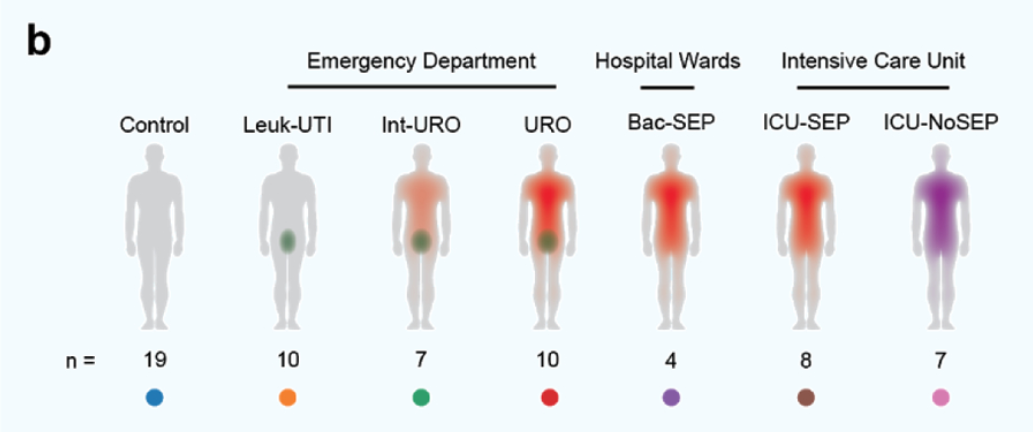

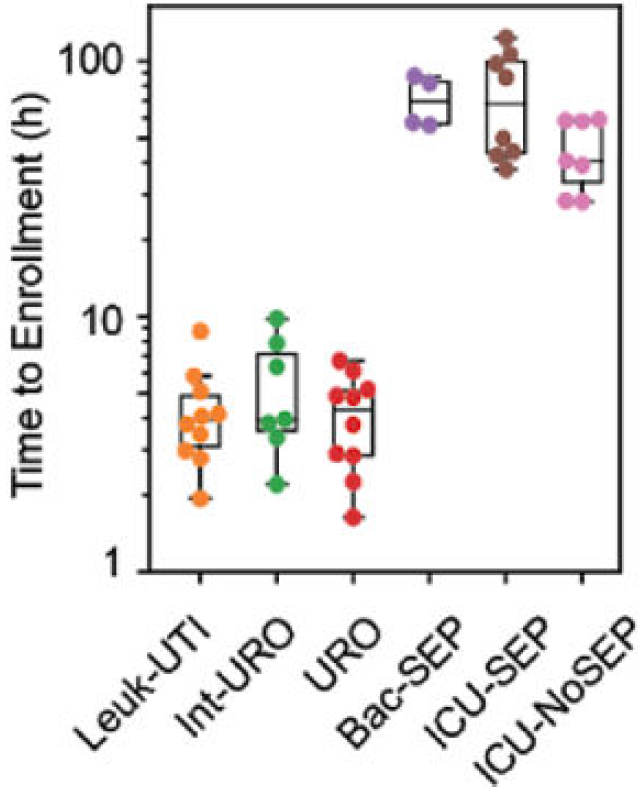

In [8]:
# Original version of datasets

dir = r'./data/scp_gex_matrix/processed_sepsis_7533/'
batchsize = 32
nbatches = len(batch_lst)
ngenes = 7533
seed = 0

torch.manual_seed(seed)
np.random.seed(seed)

sc_datasets = []
train_loaders = []
test_loaders = []
n = 0
for name, idx in batch_lst:
#     print(type(name), idx)
    counts_rna = np.array(sparse.load_npz(os.path.join(dir, '{}/mtx_{}_batch_{}.npz'.format(name,name,idx))).todense())
    anno = pd.read_csv(os.path.join(dir, '{}/meta_{}_batch{}.csv'.format(name, name,idx)))["Cell_Type"]
    anno = le.fit_transform(anno)
    sc_dataset = dataset(counts = counts_rna, anno = anno, time_point = [n%7] * len(anno), 
                         batch_id = [n] * len(anno), group_id = [n%7] * len(anno))
    sc_datasets.append(sc_dataset)
    train_loaders.append(DataLoader(sc_dataset, batch_size = batchsize, shuffle = True))
    test_loaders.append(DataLoader(sc_dataset, batch_size = len(sc_dataset), shuffle = False))
    n += 1
    print(name, idx,'Finished')

Control 4 Finished
Leuk-UTI 3 Finished
Int-URO 7 Finished
URO 13 Finished
Bac-SEP 31 Finished
ICU-SEP 27 Finished
ICU-NoSEP 19 Finished
Control 6 Finished
Leuk-UTI 5 Finished
Int-URO 11 Finished
URO 15 Finished
Bac-SEP 33 Finished
ICU-SEP 29 Finished
ICU-NoSEP 21 Finished


In [11]:
le.fit_transform(['T', 'Mono', 'NK', 'B', 'DC'])

array([4, 2, 3, 0, 1])

         Falling back to preprocessing with `sc.pp.pca` and default params.


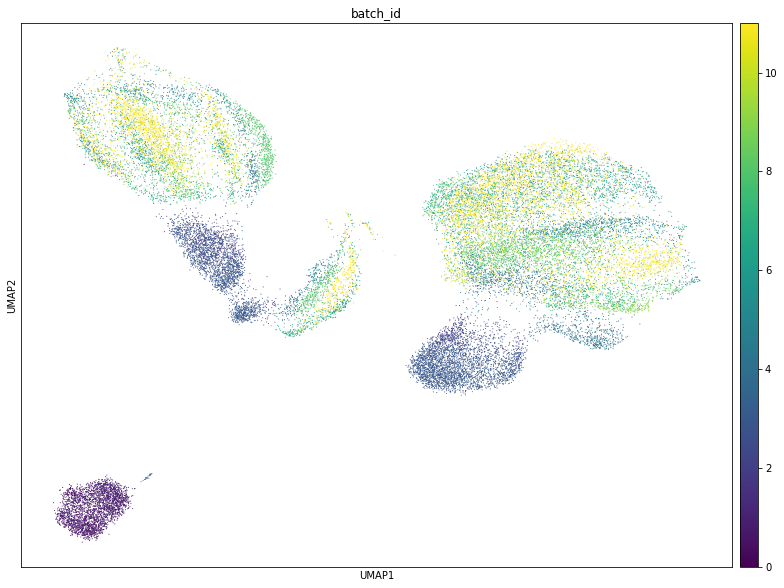

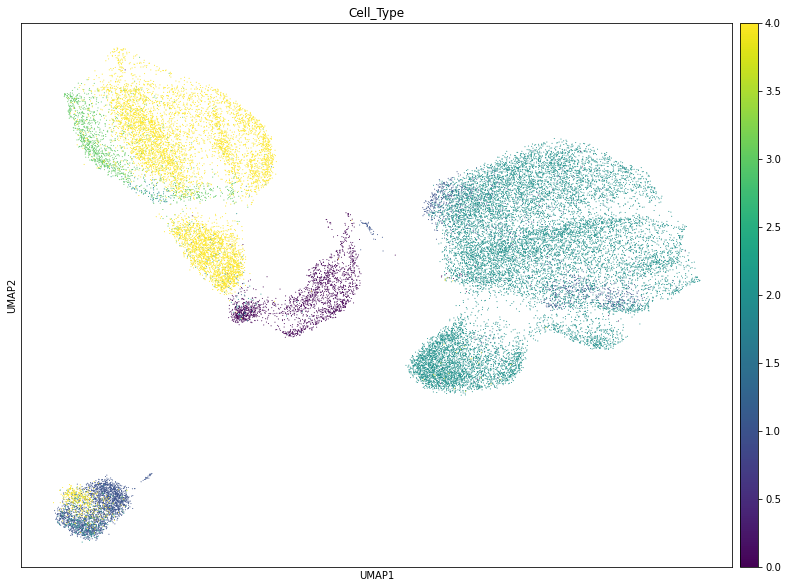

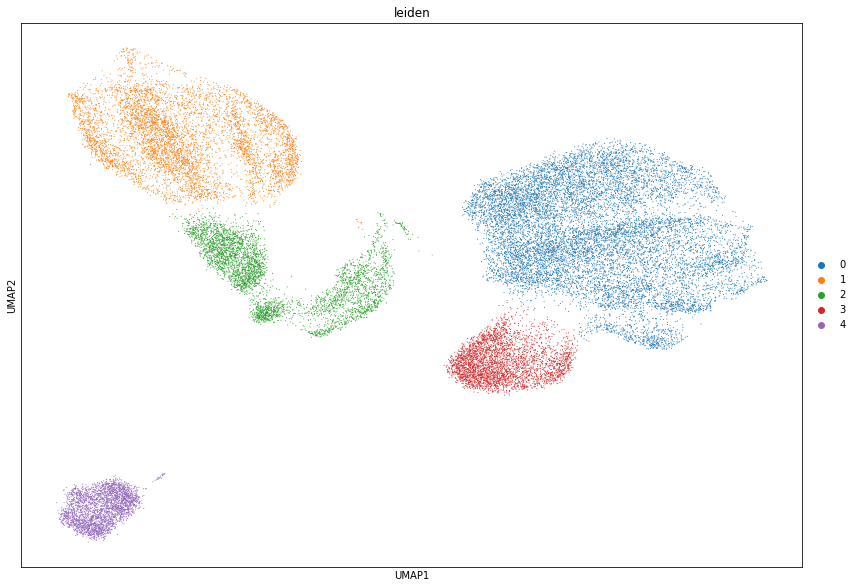

In [13]:
import scanpy as sc
from matplotlib import rcParams

counts_norms = []
annos = []
batch_ids = []
for batch in range(nbatches):
    counts_norms.append(sc_datasets_raw[batch].counts_norm)
    annos.append(sc_datasets_raw[batch].anno)
    batch_ids.append(sc_datasets_raw[batch].batch_id)
adata = ad.AnnData(np.concatenate(counts_norms, axis = 0))

adata.obs['Cell_Type'] = np.concatenate(annos)
adata.obs['batch_id'] = np.concatenate(batch_ids)

sc.pp.neighbors(adata, n_neighbors=15, n_pcs=40)
sc.tl.umap(adata)

save = None
rcParams['figure.figsize'] = 14, 10
sc.pl.umap(adata, color = ['batch_id'], save = save)
sc.pl.umap(adata, color = ['Cell_Type'], save = save)

sc.tl.leiden(adata, resolution = 0.1)
sc.pl.umap(adata, color = ['leiden'], save=save)

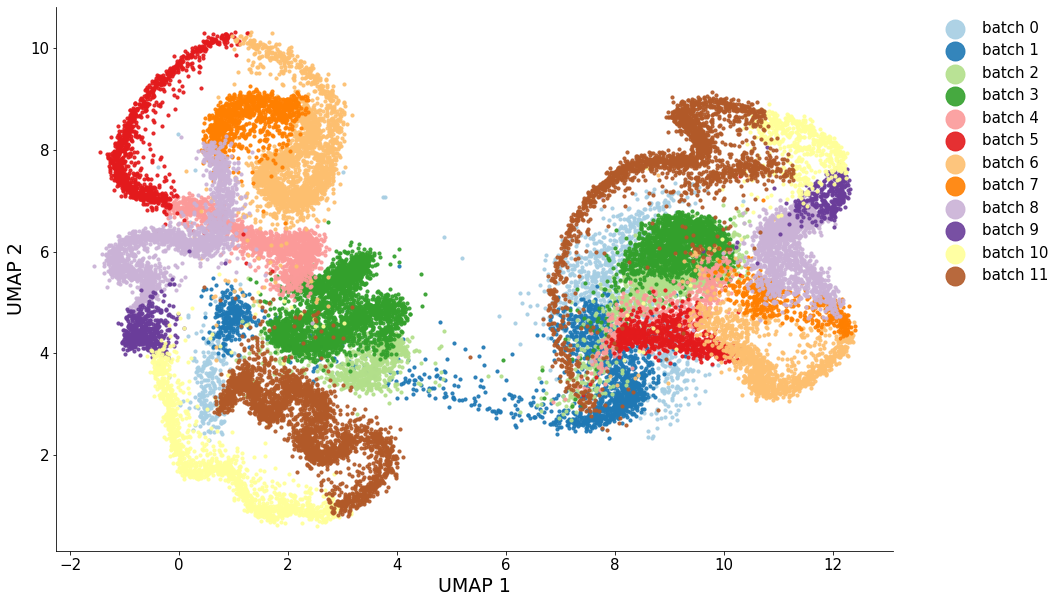

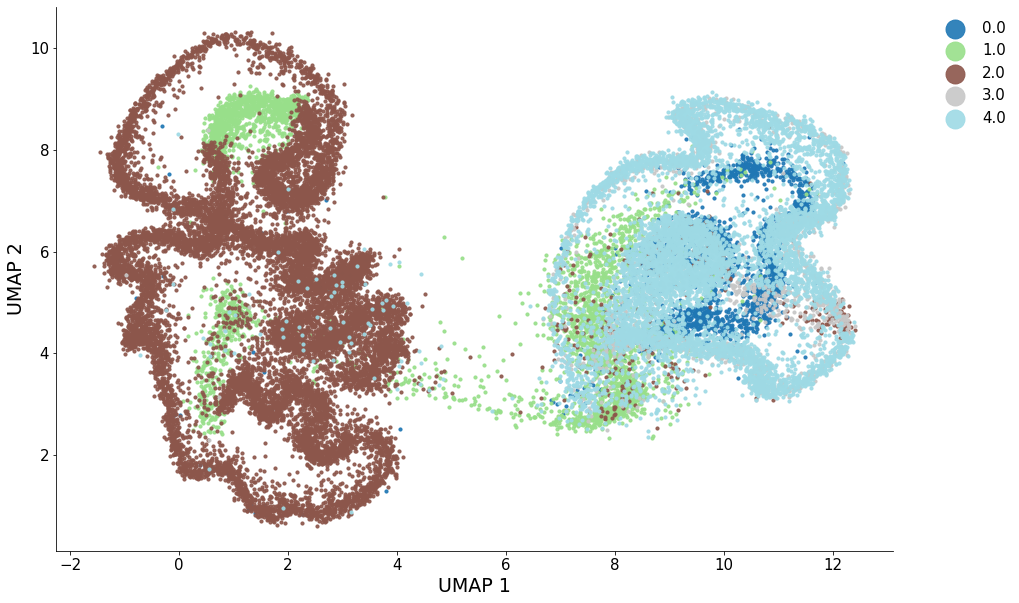

In [8]:
# before integration
umap_op = UMAP(n_components = 2, n_neighbors = 15, min_dist = 0.3, random_state = 0) 
counts_norms = []
annos = []
batch_ids = []
for batch in range(nbatches):
    counts_norms.append(sc_datasets_raw[batch].counts_norm)
    annos.append(sc_datasets_raw[batch].anno)
    batch_ids.append(sc_datasets_raw[batch].batch_id)

x_umap = umap_op.fit_transform(np.concatenate(counts_norms, axis = 0))
# separate into batches
x_umaps = []
for batch in range(nbatches):
    if batch == 0:
        start_pointer = 0
        end_pointer = start_pointer + counts_norms[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])
    elif batch == (nbatches - 1):
        start_pointer = start_pointer + counts_norms[batch - 1].shape[0]
        x_umaps.append(x_umap[start_pointer:,:])
    else:
        start_pointer = start_pointer + counts_norms[batch - 1].shape[0]
        end_pointer = start_pointer + counts_norms[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])

save_file = None

utils.plot_latent(x_umaps, annos = annos, mode = "modality", save = save_file, figsize = (15,10), axis_label = "UMAP", markerscale = 6)

utils.plot_latent(x_umaps, annos = annos, mode = "joint", save = save_file, figsize = (15,10), axis_label = "UMAP", markerscale = 6)

# utils.plot_latent(x_umaps, annos = annos, mode = "separate", save = None, figsize = (10,70), axis_label = "Latent")


In [9]:
import importlib
importlib.reload(train)

<module 'train' from './src/train.py'>

In [10]:
class SupervisedContrastiveLoss(nn.Module):
    def __init__(self, temperature=0.07):
        """
        Implementation of the loss described in the paper Supervised Contrastive Learning :
        https://arxiv.org/abs/2004.11362
        :param temperature: int
        """
        super(SupervisedContrastiveLoss, self).__init__()
        self.temperature = temperature

    def forward(self, projections, targets):
        """
        :param projections: torch.Tensor, shape [batch_size, projection_dim]
        :param targets: torch.Tensor, shape [batch_size]
        :return: torch.Tensor, scalar
        """
        device = torch.device("cuda") if projections.is_cuda else torch.device("cpu")

        dot_product_tempered = torch.mm(projections, projections.T) / self.temperature
        # Minus max for numerical stability with exponential. Same done in cross entropy. Epsilon added to avoid log(0)
        exp_dot_tempered = (
            torch.exp(dot_product_tempered - torch.max(dot_product_tempered, dim=1, keepdim=True)[0]) + 1e-5
        )

        mask_similar_class = (targets.unsqueeze(1).repeat(1, targets.shape[0]) == targets).to(device)
        mask_anchor_out = (1 - torch.eye(exp_dot_tempered.shape[0])).to(device)
        mask_combined = mask_similar_class * mask_anchor_out
        cardinality_per_samples = torch.sum(mask_combined, dim=1)

        log_prob = -torch.log(exp_dot_tempered / (torch.sum(exp_dot_tempered * mask_anchor_out, dim=1, keepdim=True)))
        supervised_contrastive_loss_per_sample = torch.sum(log_prob * mask_combined, dim=1) / cardinality_per_samples
        supervised_contrastive_loss = torch.mean(supervised_contrastive_loss_per_sample)

        return supervised_contrastive_loss

In [79]:
# Considering UTI label

def train_epoch_mmd(model_dict, train_data_loaders, test_data_loaders, optimizer, 
                    n_epoches = 100, interval = 10, lamb_mmd = 1e-3, lamb_pi = 1e-5, 
                    use_zinb = True, contr_factor=1e-1, contr_loss_group_factor = 5e-2, contr_loss=None, time_dim = 5, group_dim = 5):
    group_dim_label = time_dim + group_dim
    loss_zinb_tests = []
    loss_mmd_tests = []
    loss_tests = []
    contr_loss_tests = []
#     contr_loss_group = CircleLoss(m=0.25, gamma= 1e-1)
    contr_loss_group = SupervisedContrastiveLoss()
    contr_feature = 'time_point'
    contr_feature_1 = 'group_id'
    for epoch in range(n_epoches + 1):
        # train the model
        for data_batch in zip(*train_data_loaders):
            loss_mmd = 0
            loss_zinb = 0
            loss_contr = 0
            loss_contr_group = 0
            for idx, x in enumerate(data_batch):
                z = model_dict["encoder"](x["count_stand"].to(device))
                mu, pi, theta = model_dict["decoder"](z)
                # negative log likelihood
                if use_zinb:
                    loss_zinb += ZINB(pi = pi, theta = theta, scale_factor = x["libsize"].to(device), ridge_lambda = lamb_pi).loss(y_true = x["count"].to(device), y_pred = mu)
                else:
                    # if not use ZINB, then assume the data is Gaussian instead
                    loss_zinb += (mu * x["libsize"].to(device) - x["count"].to(device)).pow(2).sum()
                    
                # if there are more than 1 batch, calculate mmd loss between current batch and previous batch
                if (len(data_batch) >= 2) & (idx > 0):
                    loss_mmd += maximum_mean_discrepancy(z_pre[:, group_dim_label:], z[:, group_dim_label:])
                    if contr_loss:
                        loss_contr += contr_loss(torch.cat((z[:, :time_dim], z_pre[:, :time_dim]), dim=0).to(device), torch.cat((x[contr_feature], label_pre), dim = 0).to(device))
                        loss_contr_group += contr_loss_group(torch.cat((z[:, time_dim:group_dim_label], z_pre[:, time_dim:group_dim_label]), dim=0).to(device), torch.cat((x[contr_feature_1], type_pre), dim = 0).to(device))
                    else:
                        loss_contr += torch.FloatTensor([0]).to(device)
                else:
                    loss_mmd += torch.FloatTensor([0]).to(device)

                z_pre = z.clone()
                label_pre = (x[contr_feature]).clone()
                type_pre = (x[contr_feature_1]).clone()

            loss = loss_zinb + lamb_mmd * loss_mmd + loss_contr * contr_factor + loss_contr_group * contr_loss_group_factor
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # test the model
        if epoch % interval == 0:
            loss_mmd_test = 0
            loss_zinb_test = 0 
            loss_contr_test = 0
            loss_contr_group_test = 0
            for data_batch in zip(*test_data_loaders):
                with torch.no_grad():
                    for idx, x in enumerate(data_batch):
                        z = model_dict["encoder"](x["count_stand"].to(device))
                        mu, pi, theta = model_dict["decoder"](z)
                        if use_zinb:
                            loss_zinb_test += ZINB(pi = pi, theta = theta, scale_factor = x["libsize"].to(device), ridge_lambda = lamb_pi).loss(y_true = x['count'].to(device), y_pred = mu)
                        else:
                            loss_zinb_test += (mu * x["libsize"].to(device) - x["count"].to(device)).pow(2).sum()

                        if (len(data_batch) >= 2) & (idx > 0):
                            loss_mmd_test += maximum_mean_discrepancy(z_pre[:, group_dim_label:], z[:, group_dim_label:])

                            if contr_loss:
                                loss_contr_test += contr_loss(torch.cat((z[:, :time_dim], z_pre[:, :time_dim]), dim=0), torch.cat((x[contr_feature], label_pre)))
                                loss_contr_group_test += contr_loss_group(torch.cat((z[:, time_dim:group_dim_label], z_pre[:, time_dim:group_dim_label]), dim=0), torch.cat((x[contr_feature_1], type_pre), dim = 0))
                            else: 
                                loss_contr_test = 0
                        else:
                            loss_mmd_test += torch.FloatTensor([0]).to(device)
                        z_pre = z.clone()
                        label_pre = torch.Tensor(x[contr_feature]).clone()
                        type_pre = torch.Tensor(x[contr_feature_1]).clone()
                        loss_test = loss_zinb_test + lamb_mmd * loss_mmd_test + loss_contr_test * contr_factor + loss_contr_group_test * contr_loss_group_factor

            info = [
                'mmd loss: {:.3f}'.format(loss_mmd_test.item()),
                'ZINB loss: {:.3f}'.format(loss_zinb_test.item()),
                'overall loss: {:.3f}'.format(loss_test.item()),
                'contrastive loss: {:.3f}'.format(loss_contr_test.item()),
            ]

            print("epoch: ", epoch)
            for i in info:
                print("\t", i)
            contr_loss_tests.append(loss_contr_test.item())
            loss_mmd_tests.append(loss_mmd_test.item())
            loss_zinb_tests.append(loss_zinb_test.item())
            loss_tests.append(loss_test.item())
    return loss_tests, loss_mmd_tests, loss_zinb_tests, contr_loss_tests

SyntaxError: invalid character in identifier (<ipython-input-79-63b12df18bce>, line 12)

In [80]:
# initialize the model
ldim = 32
lr = 5e-4
model_dict = {}
model_dict["encoder"] = model.Encoder(features = [ngenes, 256, 32, ldim], dropout_rate = 0, negative_slope = 0.2).to(device)
model_dict["decoder"] = model.Decoder(features = [ldim, 32, 256, ngenes], dropout_rate = 0, negative_slope = 0.2).to(device)
# initialize the optimizer
param_to_optimize = [
    {'params': model_dict["encoder"].parameters()},
    {'params': model_dict["decoder"].parameters()}
]

optim_ae = torch.optim.Adam(param_to_optimize, lr=lr)

# use Circle loss to distinguish different time points
# contrastive_loss = CircleLoss(m=0.25, gamma= 1e-2)
# contrastive_loss = TripletLoss(margin=0.3)
# contrastive_loss = torch.nn.CrossEntropyLoss()
# contrastive_loss = SupConLoss()
contrastive_loss = SupervisedContrastiveLoss()
contr_factor = 1e-5
contr_loss_group_factor = 1e-5
n_epoches = 30
time_dim = 15
group_dim = 5
losses = train_epoch_mmd(model_dict, train_data_loaders = train_loaders, test_data_loaders = test_loaders, 
                      optimizer = optim_ae, n_epoches = n_epoches, interval = 10, lamb_mmd = 5e-2, 
                      lamb_pi = 1e-5, use_zinb = True, contr_factor=contr_factor,contr_loss=contrastive_loss, 
                        time_dim = time_dim, group_dim = group_dim, contr_loss_group_factor = contr_loss_group_factor)

epoch:  0
	 mmd loss: 0.123
	 ZINB loss: 4.832
	 overall loss: 4.840
	 contrastive loss: 58.205
epoch:  10
	 mmd loss: 0.056
	 ZINB loss: 2.432
	 overall loss: 2.436
	 contrastive loss: 58.383
epoch:  20
	 mmd loss: 0.050
	 ZINB loss: 2.338
	 overall loss: 2.342
	 contrastive loss: 58.430
epoch:  30
	 mmd loss: 0.045
	 ZINB loss: 2.293
	 overall loss: 2.296
	 contrastive loss: 58.622


## Metrics for Benchmarking
**I've implemented: 
        NMI, 
        ARI, 
        graph_connectivity,
to help tune model, mostly referring to CLEAR model and paper "Benchmarking atlas-level data integration in single-cell genomics"** - Xinye


In [81]:
# zs = []
# for data_batch in zip(*test_loaders):
#     with torch.no_grad():
#         for idx, x in enumerate(data_batch):
#             z = model_dict["encoder"](x["count_stand"].to(device))
#             mu, pi, theta = model_dict["decoder"](z)
#             zs.append(z.cpu().detach().numpy())

# obs = pd.DataFrame()
# data = ad.AnnData(np.concatenate(zs))
# data.obs['label'] = pd.Series([str(i) for i in np.concatenate(annos)], dtype="category").values
# data.obs['batch'] = pd.Series([str(i) for i in np.concatenate(batch_ids)], dtype="category").values

# # ari and nmi
# ari_nmi(data, annos, resolution=0.08, show_fig=True)
# print('Computing kBET')
# print('kBET score:', kBET(data, 'batch', 'label', embed=None))
# # print("/nGraph Connectivity Score:", graph_connectivity(data, 'label'))

## Loss plot
The change of loss function with iterations

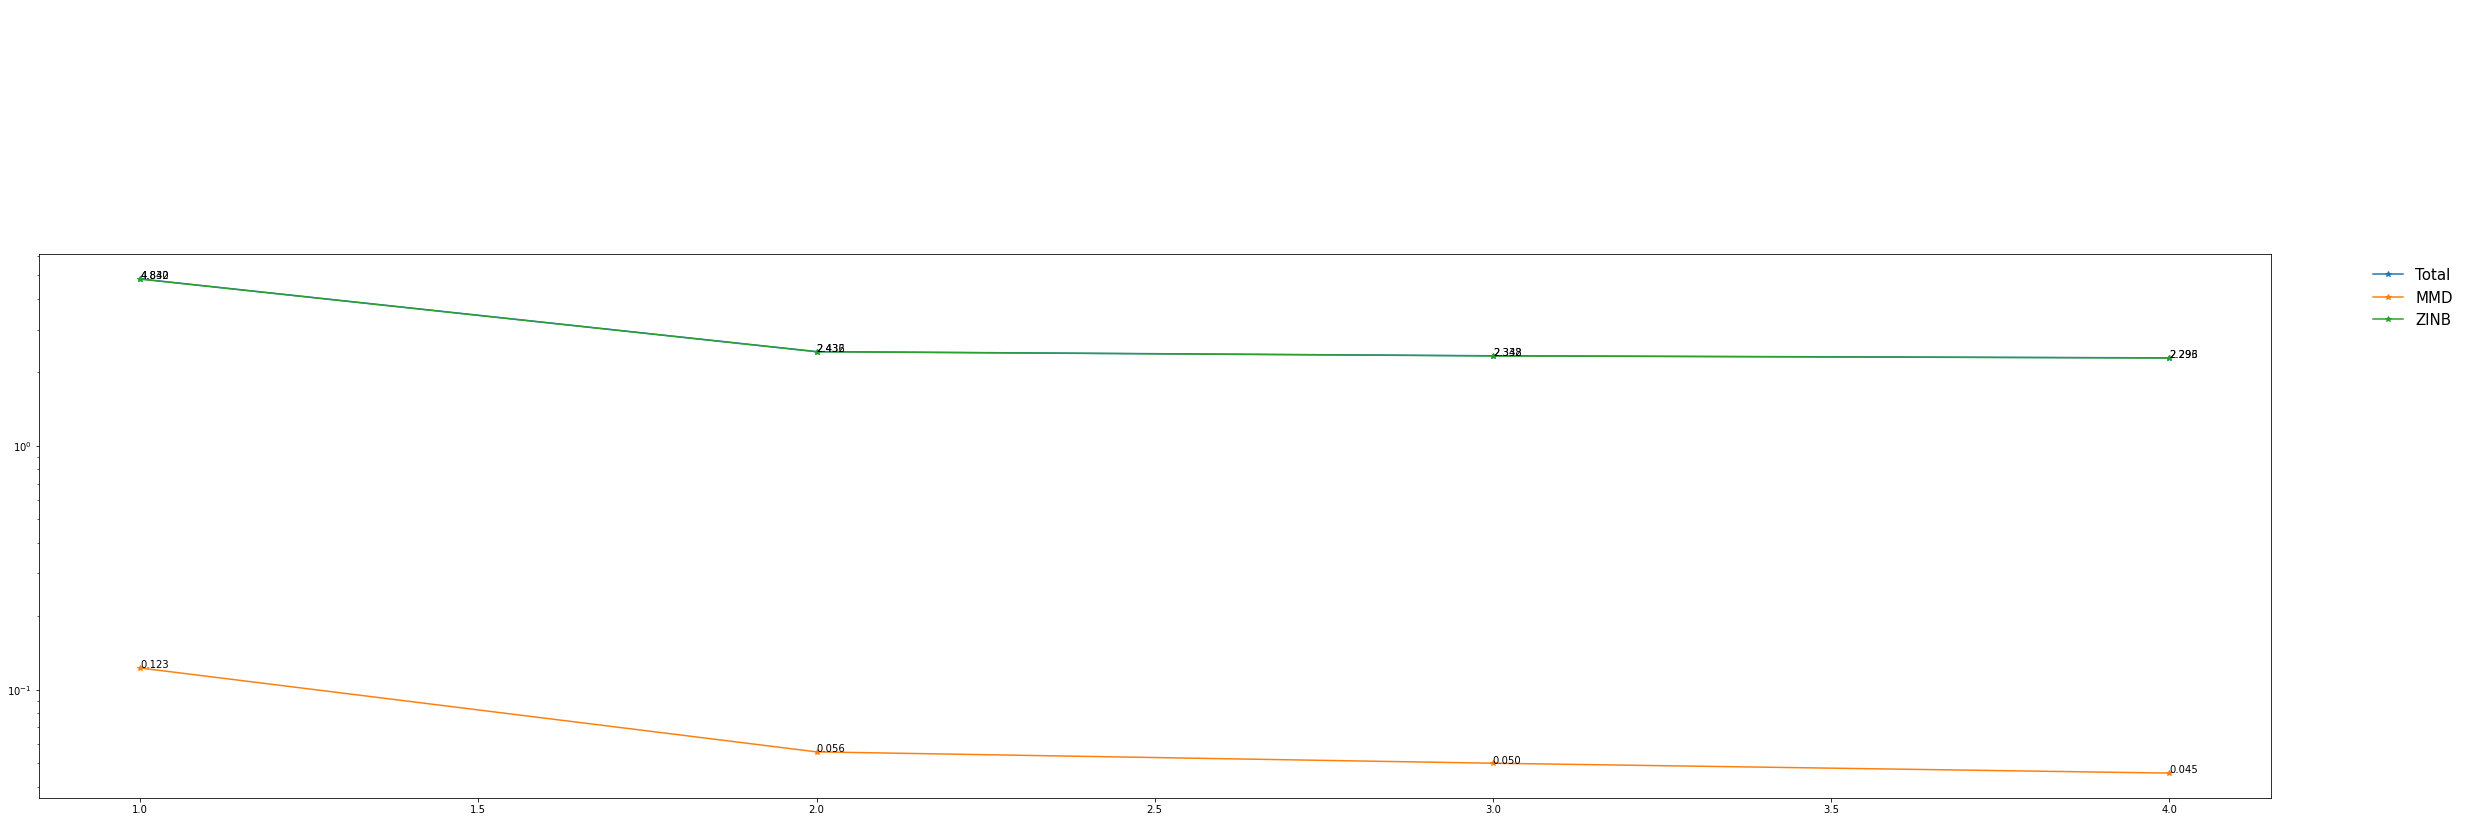

In [82]:

loss_total = losses[0]
loss_mmd = losses[1]
loss_zinb = losses[2]
loss_triplet = losses[3]

iterations = np.arange(1, len(loss_mmd) + 1)
fig = plt.figure(figsize = (40, 10))
ax = fig.add_subplot()
ax.plot(iterations, loss_total, "-*", label = "Total")
ax.plot(iterations, loss_mmd, "-*", label = "MMD")
ax.plot(iterations, loss_zinb, "-*",label = "ZINB")
# ax.plot(iterations, loss_triplet.cpu(), "-*",label = "TRIPLET")
ax.legend(loc='upper left', prop={'size': 15}, frameon = False, ncol = 1, bbox_to_anchor=(1.04, 1))
ax.set_yscale("log")
for i,j in zip(iterations,loss_zinb):
    ax.annotate("{:.3f}".format(j),xy=(i,j))
for i,j in zip(iterations,loss_mmd):
    ax.annotate("{:.3f}".format(j),xy=(i,j))
for i,j in zip(iterations,loss_total):
    ax.annotate("{:.3f}".format(j),xy=(i,j))
for i,j in zip(iterations,loss_triplet):
    ax.annotate("{:.3f}".format(j),xy=(i,j)) 

- ## 0, 2
- ## 2, 11
- ## 4, 11
- ## 0, 4
- ## 6. 8
- ## 5, 7

In [118]:
path = '/net/csefiles/xzhanglab/xzhao429/Projects/AntennaVAE/sepsis_results/sep_uti_1/'
batch_ids = [4, 11]
save_permit = True

## Visualize embedding without UTI dimentions

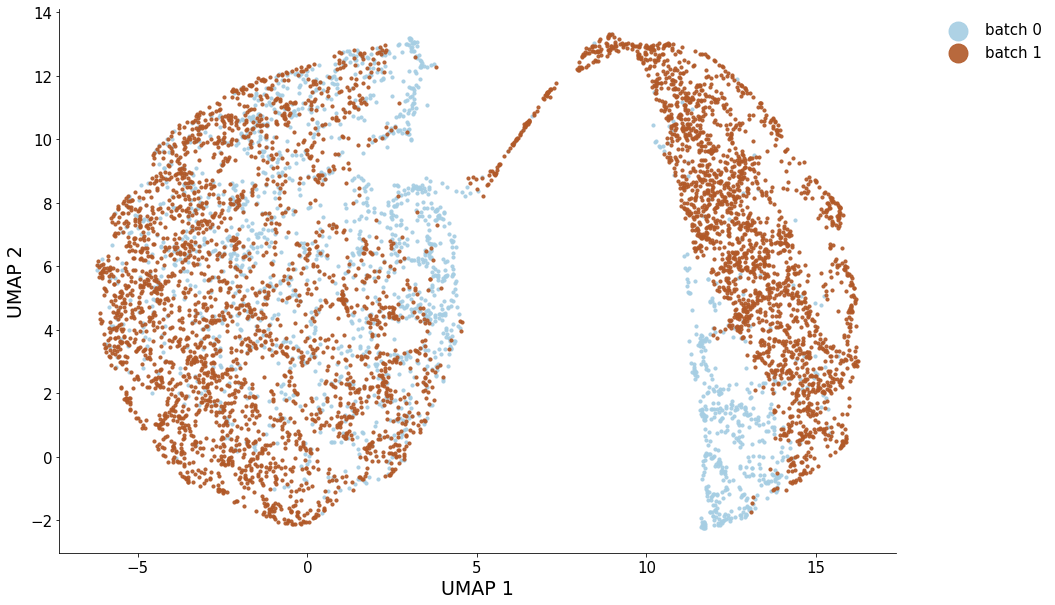

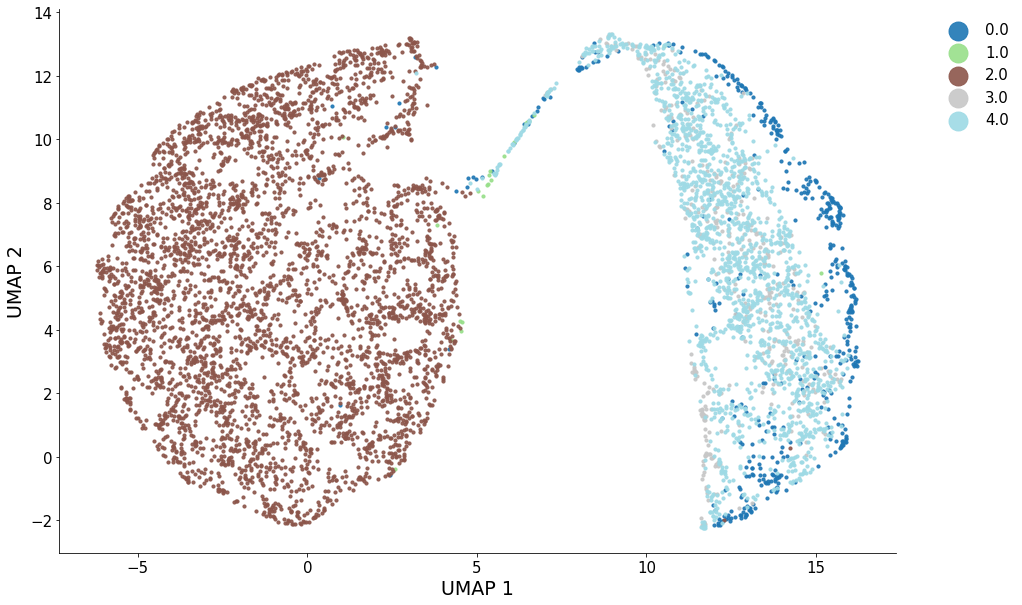

In [119]:
zs = []
# batch_ids = [0, 6]
test_loaders_sub = [test_loaders_raw[i] for i in batch_ids]
nbatches_sub = len(test_loaders_sub)
annos_sub = []

for data_batch in zip(*test_loaders_sub):
    with torch.no_grad():
        for idx, x in enumerate(data_batch):
            z = model_dict["encoder"](x["count_stand"].to(device))
            mu, pi, theta = model_dict["decoder"](z)
            annos_sub.append(x['anno'])
            zs.append(z.cpu().detach().numpy())

x_umap = umap_op.fit_transform(np.concatenate((np.concatenate(zs, axis = 0)[:, : time_dim], np.concatenate(zs, axis = 0)[:, time_dim + group_dim:]), axis=1))
# separate into batches
x_umaps_no_time = []

for batch in range(nbatches_sub):
    if batch == 0:
        start_pointer = 0
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps_no_time.append(x_umap[start_pointer:end_pointer,:])
    elif batch == (nbatches - 1):
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        x_umaps_no_time.append(x_umap[start_pointer:,:])
    else:
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps_no_time.append(x_umap[start_pointer:end_pointer,:])
# comment = 'NO_TIME_DIMS_15_TRIPLET_m_0.25_gamma_1e-2'
comment = 'NO_UTI'
save_file_batch = path + 'batch_contr_{}_batch_{}_&_{}_epoch_{}.png'.format(comment, batch_ids[0], batch_ids[1], n_epoches)
save_file_type = path + 'type_contr_{}_batch_{}_&_{}_epoch_{}.png'.format(comment, batch_ids[0], batch_ids[1], n_epoches)
save_file = None
if not save_permit:
    save_file_batch = save_file
    save_file_type = save_file
utils.plot_latent(x_umaps_no_time, annos = annos_sub, mode = "modality", save = save_file_batch, figsize = (15,10), axis_label = "UMAP", markerscale = 6)

utils.plot_latent(x_umaps_no_time, annos = annos_sub, mode = "joint", save = save_file_type, figsize = (15,10), axis_label = "UMAP", markerscale = 6)
# utils.plot_latent(x_umaps, annos = annos, mode = "separate", save = None, figsize = (10,70), axis_label = "Latent")


## Visualize embedding without time dimentions

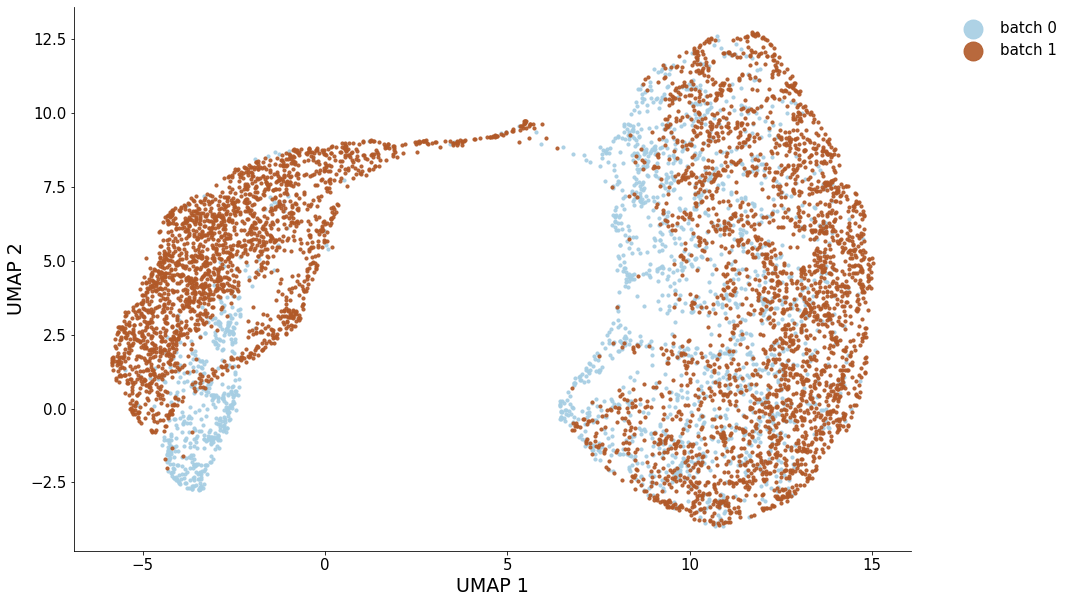

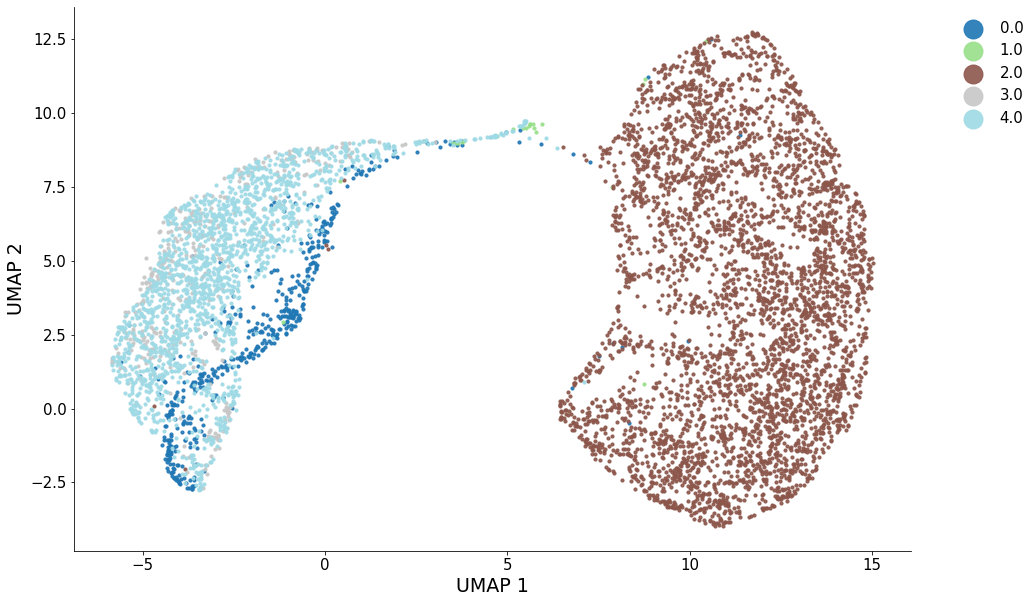

In [120]:
zs = []
# batch_ids = [0, 6]
test_loaders_sub = [test_loaders_raw[i] for i in batch_ids]
nbatches_sub = len(test_loaders_sub)
annos_sub = []

for data_batch in zip(*test_loaders_sub):
    with torch.no_grad():
        for idx, x in enumerate(data_batch):
            z = model_dict["encoder"](x["count_stand"].to(device))
            mu, pi, theta = model_dict["decoder"](z)
            annos_sub.append(x['anno'])
            zs.append(z.cpu().detach().numpy())

x_umap = umap_op.fit_transform(np.concatenate(zs, axis = 0)[:, time_dim:])
# separate into batches
x_umaps_no_time = []

for batch in range(nbatches_sub):
    if batch == 0:
        start_pointer = 0
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps_no_time.append(x_umap[start_pointer:end_pointer,:])
    elif batch == (nbatches - 1):
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        x_umaps_no_time.append(x_umap[start_pointer:,:])
    else:
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps_no_time.append(x_umap[start_pointer:end_pointer,:])
# comment = 'NO_TIME_DIMS_15_TRIPLET_m_0.25_gamma_1e-2'
comment = 'NO_TIME'
save_file_batch = path + 'batch_contr_{}_batch_{}_&_{}_epoch_{}.png'.format(comment, batch_ids[0], batch_ids[1], n_epoches)
save_file_type = path + 'type_contr_{}_batch_{}_&_{}_epoch_{}.png'.format(comment, batch_ids[0], batch_ids[1], n_epoches)
save_file = None
if not save_permit:
    save_file_batch = save_file
    save_file_type = save_file
utils.plot_latent(x_umaps_no_time, annos = annos_sub, mode = "modality", save = save_file_batch, figsize = (15,10), axis_label = "UMAP", markerscale = 6)

utils.plot_latent(x_umaps_no_time, annos = annos_sub, mode = "joint", save = save_file_type, figsize = (15,10), axis_label = "UMAP", markerscale = 6)
# utils.plot_latent(x_umaps, annos = annos, mode = "separate", save = None, figsize = (10,70), axis_label = "Latent")


## Visualize embedding without time and UTI dimentions

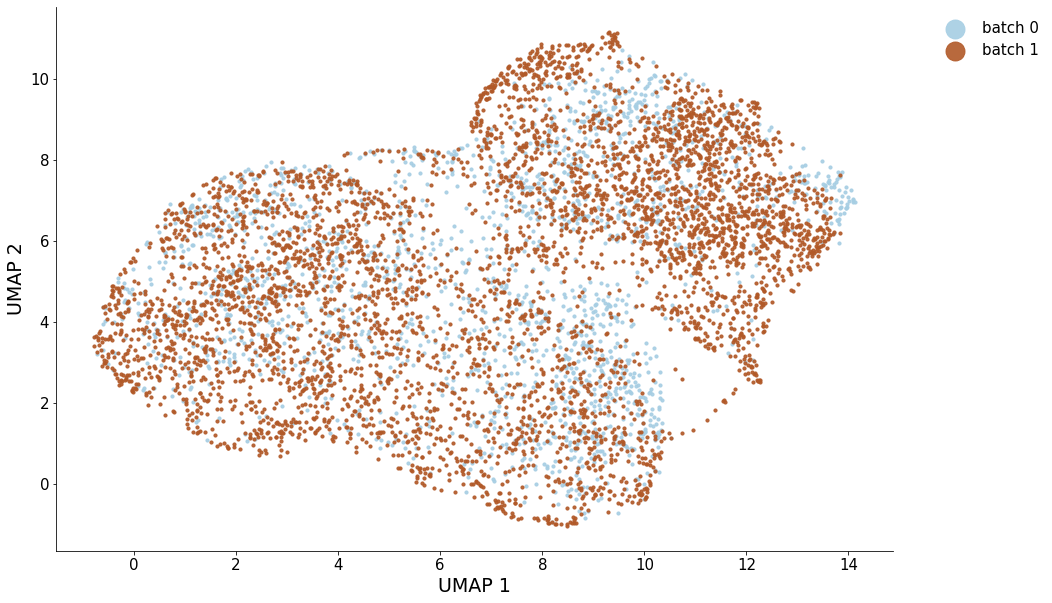

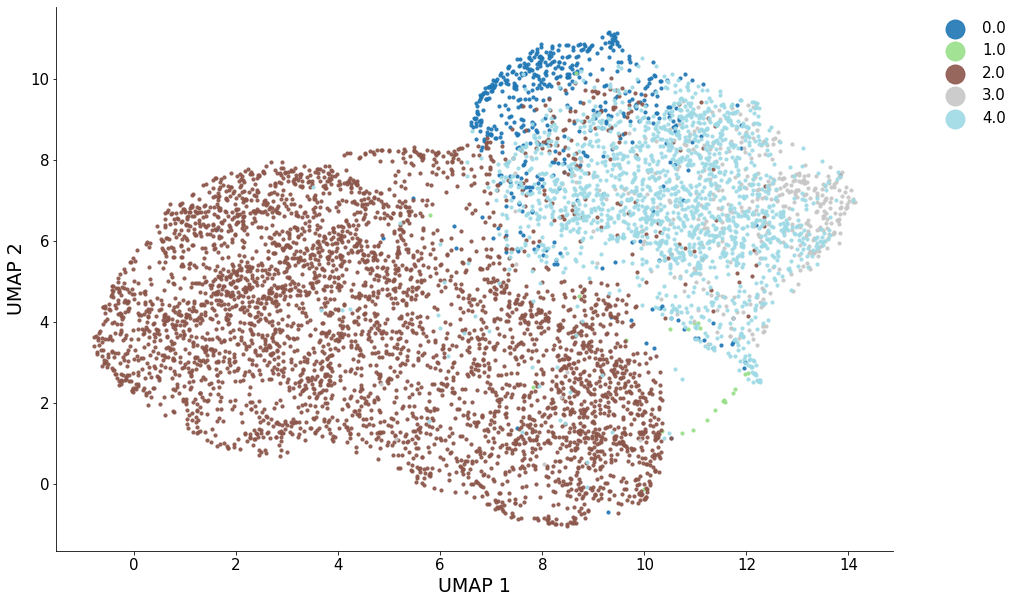

In [121]:
zs = []
# batch_ids = [0, 6]
test_loaders_sub = [test_loaders_raw[i] for i in batch_ids]
nbatches_sub = len(test_loaders_sub)
annos_sub = []

for data_batch in zip(*test_loaders_sub):
    with torch.no_grad():
        for idx, x in enumerate(data_batch):
            z = model_dict["encoder"](x["count_stand"].to(device))
            mu, pi, theta = model_dict["decoder"](z)
            annos_sub.append(x['anno'])
            zs.append(z.cpu().detach().numpy())

x_umap = umap_op.fit_transform(np.concatenate(zs, axis = 0)[:, time_dim + group_dim:])
# separate into batches
x_umaps_no_time = []

for batch in range(nbatches_sub):
    if batch == 0:
        start_pointer = 0
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps_no_time.append(x_umap[start_pointer:end_pointer,:])
    elif batch == (nbatches - 1):
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        x_umaps_no_time.append(x_umap[start_pointer:,:])
    else:
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps_no_time.append(x_umap[start_pointer:end_pointer,:])
# comment = 'NO_TIME_DIMS_15_TRIPLET_m_0.25_gamma_1e-2'
comment = 'NO_TIME_NO_UTI'
save_file_batch = path + 'batch_contr_{}_batch_{}_&_{}_epoch_{}.png'.format(comment, batch_ids[0], batch_ids[1], n_epoches)
save_file_type = path + 'type_contr_{}_batch_{}_&_{}_epoch_{}.png'.format(comment, batch_ids[0], batch_ids[1], n_epoches)
save_file = None
if not save_permit:
    save_file_batch = save_file
    save_file_type = save_file
utils.plot_latent(x_umaps_no_time, annos = annos_sub, mode = "modality", save = save_file_batch, figsize = (15,10), axis_label = "UMAP", markerscale = 6)

utils.plot_latent(x_umaps_no_time, annos = annos_sub, mode = "joint", save = save_file_type, figsize = (15,10), axis_label = "UMAP", markerscale = 6)
# utils.plot_latent(x_umaps, annos = annos, mode = "separate", save = None, figsize = (10,70), axis_label = "Latent")


## Visualization of batch 5 and 6
* **Top**: cells are colored by batch ID
* **Bottom**: cells are colored by ground truth cell type


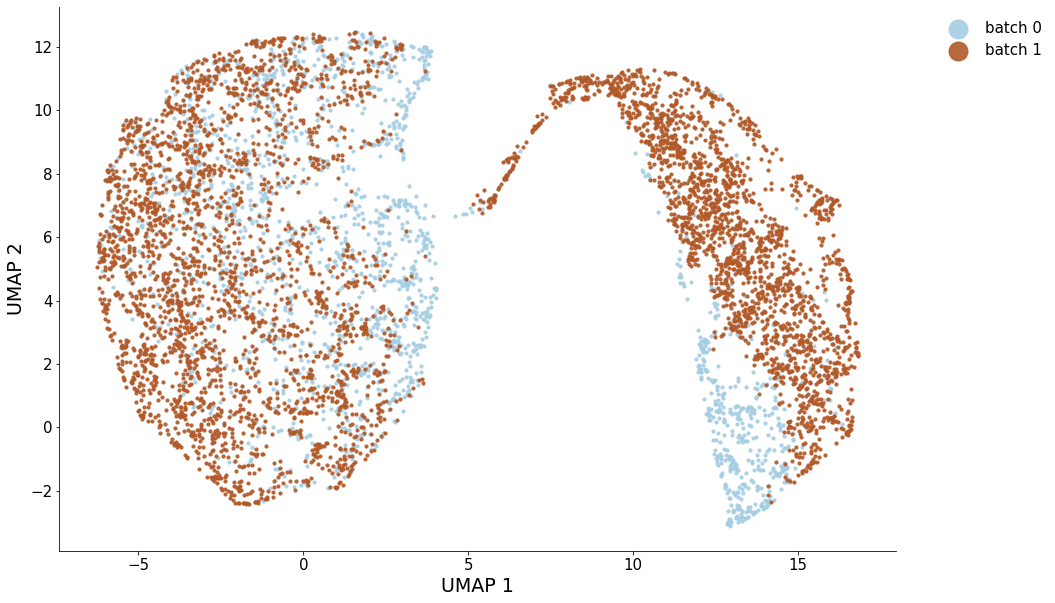

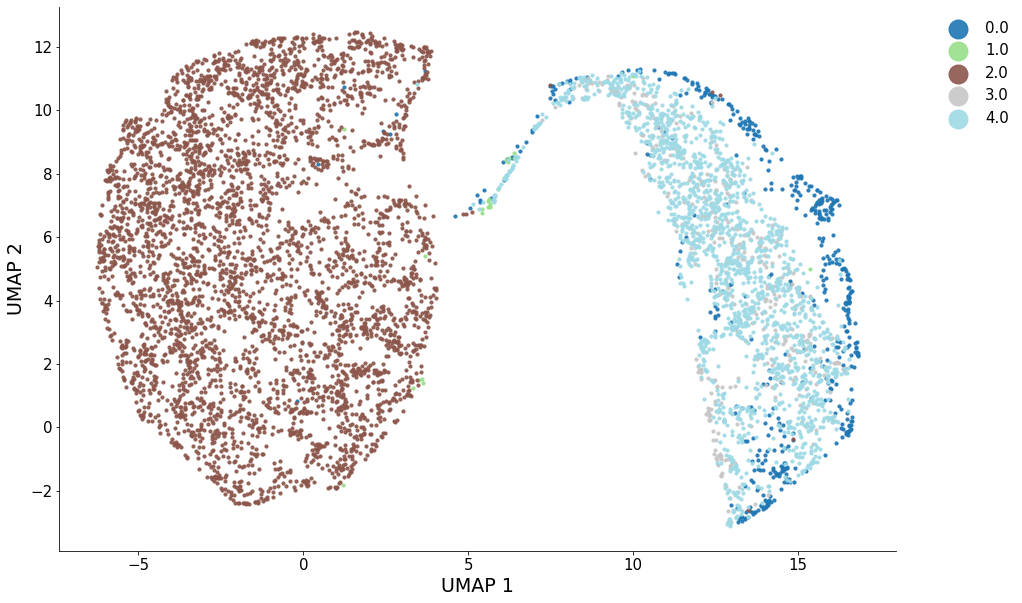

In [122]:
zs = []
# batch_ids = [8, 11]
test_loaders_sub = [test_loaders_raw[i] for i in batch_ids]
nbatches_sub = len(test_loaders_sub)
annos_sub = []

for data_batch in zip(*test_loaders_sub):
    with torch.no_grad():
        for idx, x in enumerate(data_batch):
            z = model_dict["encoder"](x["count_stand"].to(device))
            mu, pi, theta = model_dict["decoder"](z)
            annos_sub.append(x['anno'])
            zs.append(z.cpu().detach().numpy())

x_umap = umap_op.fit_transform(np.concatenate(zs, axis = 0))
# separate into batches
x_umaps_no_time = []

for batch in range(nbatches_sub):
    if batch == 0:
        start_pointer = 0
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps_no_time.append(x_umap[start_pointer:end_pointer,:])
    elif batch == (nbatches - 1):
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        x_umaps_no_time.append(x_umap[start_pointer:,:])
    else:
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps_no_time.append(x_umap[start_pointer:end_pointer,:])
# comment = 'NO_TIME_DIMS_15_TRIPLET_m_0.25_gamma_1e-2'
comment = 'SUP_WITH_TIME_UTI'
save_file_batch = path + 'batch_contr_{}_batch_{}_&_{}_epoch_{}.png'.format(comment, batch_ids[0], batch_ids[1], n_epoches)
save_file_type = path + 'type_contr_{}_batch_{}_&_{}_epoch_{}.png'.format(comment, batch_ids[0], batch_ids[1], n_epoches)
save_file = None
if not save_permit:
    save_file_batch = save_file
    save_file_type = save_file
utils.plot_latent(x_umaps_no_time, annos = annos_sub, mode = "modality", save = save_file_batch, figsize = (15,10), axis_label = "UMAP", markerscale = 6)

utils.plot_latent(x_umaps_no_time, annos = annos_sub, mode = "joint", save = save_file_type, figsize = (15,10), axis_label = "UMAP", markerscale = 6)
# utils.plot_latent(x_umaps, annos = annos, mode = "separate", save = None, figsize = (10,70), axis_label = "Latent")


## Visualization of all 8 batches
* **Top**: cells are colored by batch ID
* **Bottom**: cells are colored by ground truth cell type


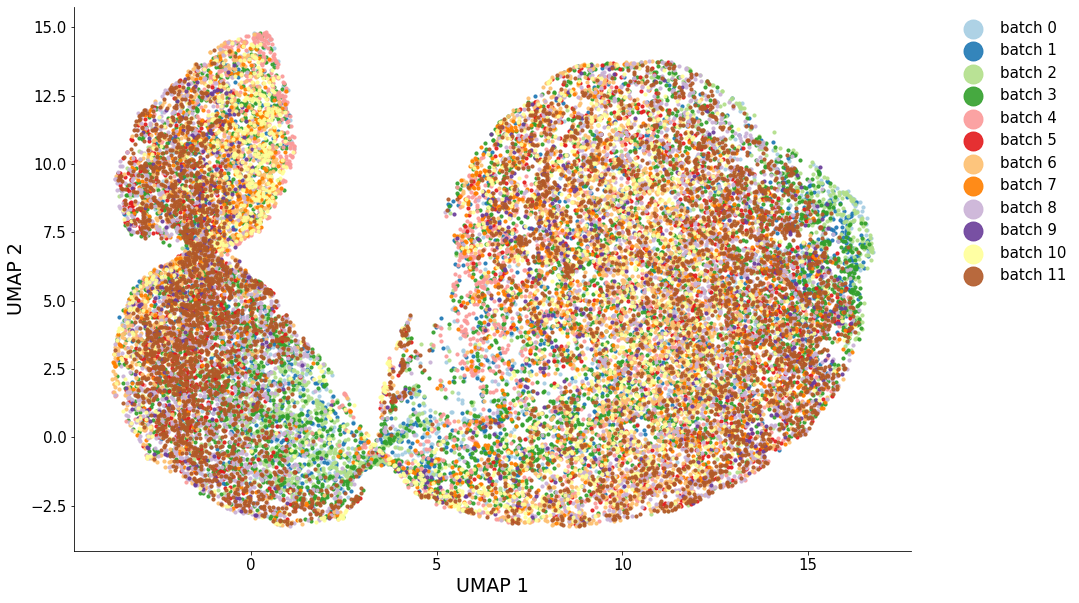

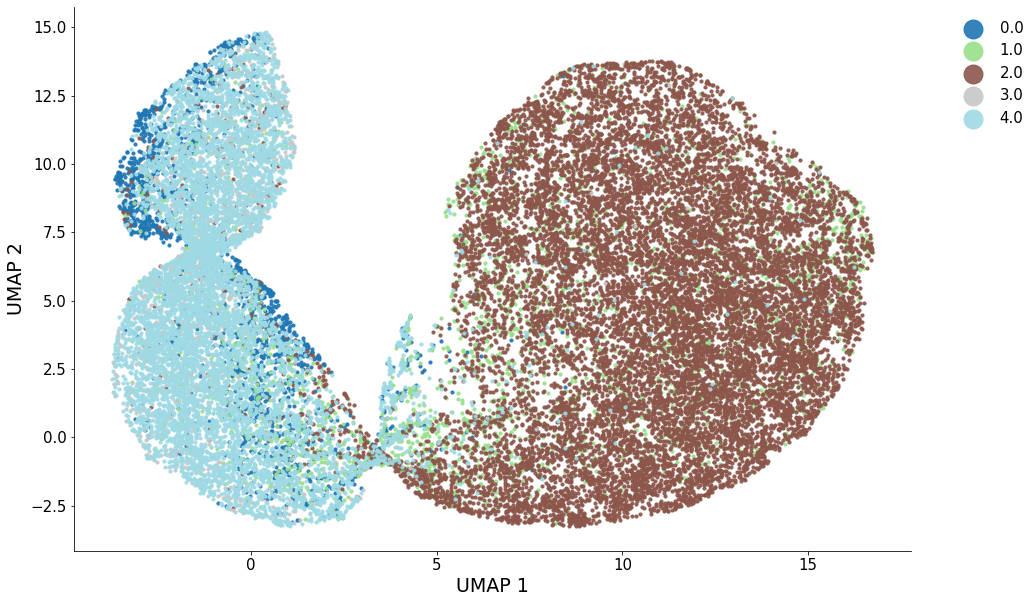

In [102]:
zs = []
annos_sub = []

for data_batch in zip(*test_loaders_raw):
    with torch.no_grad():
        for idx, x in enumerate(data_batch):
            z = model_dict["encoder"](x["count_stand"].to(device))
            mu, pi, theta = model_dict["decoder"](z)
            annos_sub.append(x['anno'])
            zs.append(z.cpu().detach().numpy())
            
x_umap = umap_op.fit_transform(np.concatenate(zs, axis = 0))
# separate into batches
x_umaps = []
for batch in range(nbatches):
    if batch == 0:
        start_pointer = 0
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])
    elif batch == (nbatches - 1):
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        x_umaps.append(x_umap[start_pointer:,:])
    else:
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])
comment = 'SUP_ALL_WIEH_TIME_UTI'
save_file_batch = path + 'batch_contr_{}_epoch_{}.png'.format(comment, n_epoches)
save_file_type = path + 'type_contr_{}_epoch_{}.png'.format(comment, n_epoches)
save_file = None
if not save_permit:
    save_file_batch = save_file
    save_file_type = save_file
utils.plot_latent(x_umaps, annos = annos_sub, mode = "modality", save = save_file_batch, figsize = (15,10), axis_label = "UMAP", markerscale = 6)

utils.plot_latent(x_umaps, annos = annos_sub, mode = "joint", save = save_file_type, figsize = (15,10), axis_label = "UMAP", markerscale = 6)

# utils.plot_latent(x_umaps, annos = annos, mode = "separate", save = None, figsize = (10,70), axis_label = "Latent")
